In [285]:
import os
import pandas as pd
import numpy as np
from src.my_settings import settings

sett = settings()

In [ ]:
pmc_coords = [(-30, -5, 64), (18, -2, 72)]
labels = ["leftPMC", "rightPMC"]

In [287]:
sub_label = '18'
task_label = 'sham'
run_label = '1'

In [288]:
from nilearn.maskers import NiftiSpheresMasker

masker = NiftiSpheresMasker(
    pmc_coords,
    radius=6,
    detrend=True,
    standardize=True,
    standardize_confounds=True,
    smoothing_fwhm=4,
    high_pass=0.008,
    t_r=sett["tr"],
    memory=os.path.join(sett["git_path"], "data", "nilearn_mem"),
    memory_level=1,
    verbose=2,
)

In [289]:
func_img = os.path.join(
            sett["derivatives_path"],
            f"sub-{sub_label}",
            "func",
            f"sub-{sub_label}_task-{task_label}_run-{run_label}{sett["space_label"]}_desc-preproc_bold.nii.gz",
            )


confounds_tsv = os.path.join(
                sett["derivatives_path"],
                f"sub-{sub_label}",
                "func",
                f"sub-{sub_label}_task-{task_label}_run-{run_label}_desc-confounds_timeseries.tsv",
            )

# load as pandas dataframe
confounds = pd.read_csv(confounds_tsv, sep="\t")

# filter
confounds = confounds[sett["confounds_of_interest"]]

# fill NaNs with 0
confounds = confounds.fillna(0)

# PHYSIO DATA REGRESSORS
physio_file = os.path.join(
    sett["bids_path"],
    "derivatives",
    "physio-out",
    f"sub-{sub_label}",
    f"sub-{sub_label}_task-{task_label}_run-{run_label}_desc-physioregressors.txt",
)

# if physio file exists, get the regressors
if os.path.exists(physio_file):
    print(
        f"Found physio file for sub-{sub_label} task-{task_label} run-{run_label}"
    )

    # read physio_file
    physio = pd.read_csv(physio_file, sep="\t", header=None)

    # rename columns to physio01, physio02, etc.
    physio.columns = [
        f"physio{i:02}" for i in range(1, physio.shape[1] + 1)
    ]

    # remove columns with only nans
    physio = physio.dropna(axis=1, how="all")

    # join confounds and physio
    confounds = pd.concat([confounds, physio], axis=1)

Found physio file for sub-18 task-sham run-1


In [290]:
time_series = masker.fit_transform(
    func_img, confounds=confounds
)

________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/Volumes/T7/BIDS-MUSICNF/derivatives/fmriprep24/sub-18/func/sub-18_task-sham_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 
<nilearn.maskers.nifti_spheres_masker._ExtractionFunctor object at 0x33c753d10>, { 'allow_overlap': False,
  'clean_kwargs': {},
  'detrend': True,
  'dtype': None,
  'high_pass': 0.008,
  'high_variance_confounds': False,
  'low_pass': None,
  'mask_img': None,
  'radius': 6,
  'reports': True,
  'seeds': [(-30, -5, 64), (18, -2, 72)],
  'smoothing_fwhm': 4,
  'standardize': True,
  'standardize_confounds': True,
  't_r': 1.5}, confounds=[             csf  white_matter   trans_x  trans_x_derivative1  trans_x_power2  \
0    615.609580    514.936629 -0.013802         0.000000e+00    1.904924e-04   
1    611.238866    515.925614 -0.029426        -1.562430e-02    8.659012e-04   
2    602

In [291]:
time_series.shape

(256, 2)

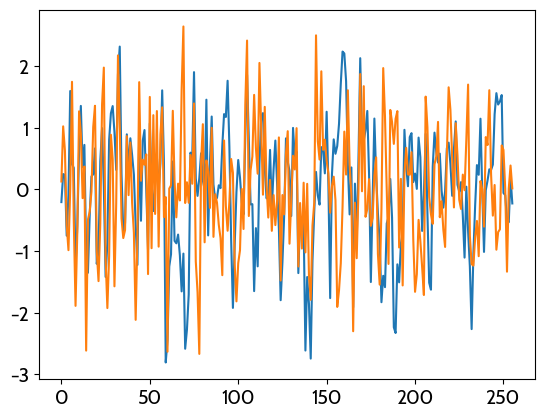

In [292]:
# plot the two time series
import matplotlib.pyplot as plt

plt.plot(time_series)

In [293]:
# get the events
events_file = os.path.join(
    sett["bids_path"],
    f"sub-{sub_label}",
    "func",
    f"sub-{sub_label}_task-{task_label}_run-{run_label}_events.tsv",
)

events = pd.read_csv(events_file, sep="\t")

# remove last 'Rest' event
events = events[:-1]

# compensate the onsets with a hemodynamic delay of 4 seconds
events["onset"] = events["onset"] + 3

# create onsets and durations in volumes, considering the TR, as integers
events["onset_volume"] = (events["onset"] / sett["tr"]).astype(int)
events["duration_volume"] = (events["duration"] / sett["tr"]).astype(int)

# get all the volume indexes for Rest
rest_volumes = []

# iterate on the events for which trial type is Rest
for idx, row in events[events["trial_type"] == "Rest"].iterrows():
    # set the start and end volume indexes for the rest period
    start = row["onset_volume"]
    end = start + row["duration_volume"]

    rest_volumes.append(np.arange(start, end))

# join all the rest periods
rest_volumes = np.concatenate(rest_volumes)
rest_volumes

array([ 10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,
        23,  24,  25,  26,  27,  28,  29,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
        69,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 130, 131, 132, 133, 134,
       135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
       148, 149, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180,
       181, 182, 183, 184, 185, 186, 187, 188, 189, 210, 211, 212, 213,
       214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226,
       227, 228, 229])

In [294]:
# get the average of the rest period
rest_mean = time_series[rest_volumes,:].mean(axis=0)
rest_mean

array([-0.14332405,  0.11508071], dtype=float32)

In [295]:
# get the signal change
signal_change = (time_series - rest_mean)
signal_change.shape

# get the bilateral signal change
signal_change_avg = signal_change.mean(axis=1)

Text(0, 0.5, 'BOLD signal change to Rest (z-score)')

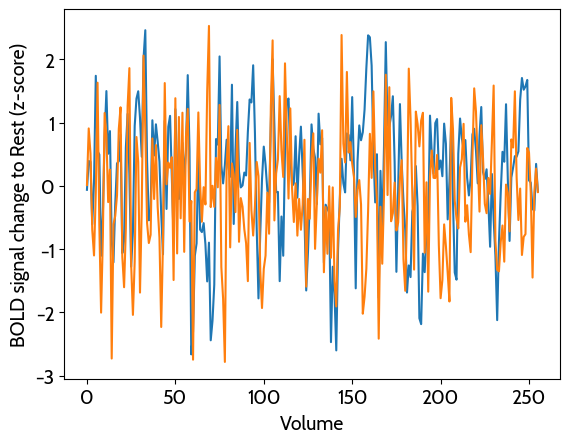

In [296]:
# plot the average of voxels_tcs
import matplotlib.pyplot as plt

plt.plot(signal_change)
plt.xlabel('Volume')
plt.ylabel('BOLD signal change to Rest (z-score)')

In [297]:
# now let's create the average timecourse of all the imagery periods
imagery_volumes = []

# iterate on the events for which trial type is Imagery
for idx, row in events[events["trial_type"] == "MotorImageryOne"].iterrows():
    # set the start and end volume indexes for the imagery period
    start = row["onset_volume"]
    end = start + 20

    imagery_volumes.append(np.arange(start, end))

imagery_volumes

[array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
        47, 48, 49]),
 array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86,
        87, 88, 89]),
 array([110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
        123, 124, 125, 126, 127, 128, 129]),
 array([150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162,
        163, 164, 165, 166, 167, 168, 169]),
 array([190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202,
        203, 204, 205, 206, 207, 208, 209]),
 array([230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242,
        243, 244, 245, 246, 247, 248, 249])]

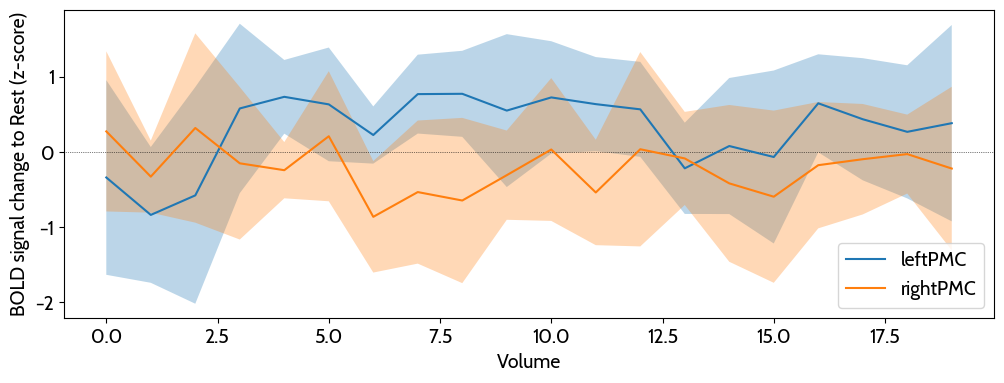

In [298]:
# Iterate on the length of imagery volumes
imagery_tcs = np.zeros((len(pmc_coords), len(imagery_volumes), len(imagery_volumes[0])))

for rr in range(len(pmc_coords)):
    for i, volumes in enumerate(imagery_volumes):
        imagery_tcs[rr, i, :] = signal_change[volumes, rr]

# plot both left and right PMC timecourses
plt.figure(figsize=(12, 4))

# dotted line at y = 0
plt.axhline(0, color="black", linestyle=":", linewidth=0.5)

for rr in range(len(pmc_coords)):
    plt.plot(imagery_tcs[rr, :, :].mean(axis=0), label=labels[rr])

    # sd
    plt.fill_between(
        np.arange(imagery_tcs.shape[2]),
        imagery_tcs[rr, :, :].mean(axis=0) - imagery_tcs[rr, :, :].std(axis=0),
        imagery_tcs[rr, :, :].mean(axis=0) + imagery_tcs[rr, :, :].std(axis=0),
        alpha=0.3,
    )

plt.xlabel('Volume')
plt.ylabel('BOLD signal change to Rest (z-score)')
plt.legend()

In [299]:
# let's estimate pearson correlation between the two PMC in a window of 8 volumes starting at each imagery block

from scipy.stats import pearsonr

window_size_online = 8
window_size_offline = 4

correlations_online = np.zeros((len(imagery_volumes), len(imagery_volumes[0])))
correlations_offline = np.zeros((len(imagery_volumes), len(imagery_volumes[0])))

# iterate on the trials
for i in range(len(imagery_volumes)):

    # iterate on the imagery volumes
    for j in range(len(imagery_volumes[0])):

        # set the window in volumes
        this_window_online = np.arange(imagery_volumes[i][j] - window_size_online, imagery_volumes[i][j])
        this_window_offline = np.arange(imagery_volumes[i][j] - window_size_offline, imagery_volumes[i][j])

        # calculate correlation
        correlations_online[i, j] = pearsonr(signal_change[this_window_online, 0], signal_change[this_window_online, 1])[0]
        correlations_offline[i, j] = pearsonr(signal_change[this_window_offline, 0], signal_change[this_window_offline, 1])[0]


In [300]:
correlations_online.shape

(6, 20)

Text(0, 0.5, 'Windowed (4 vols) PMC\n interhemispheric correlation')

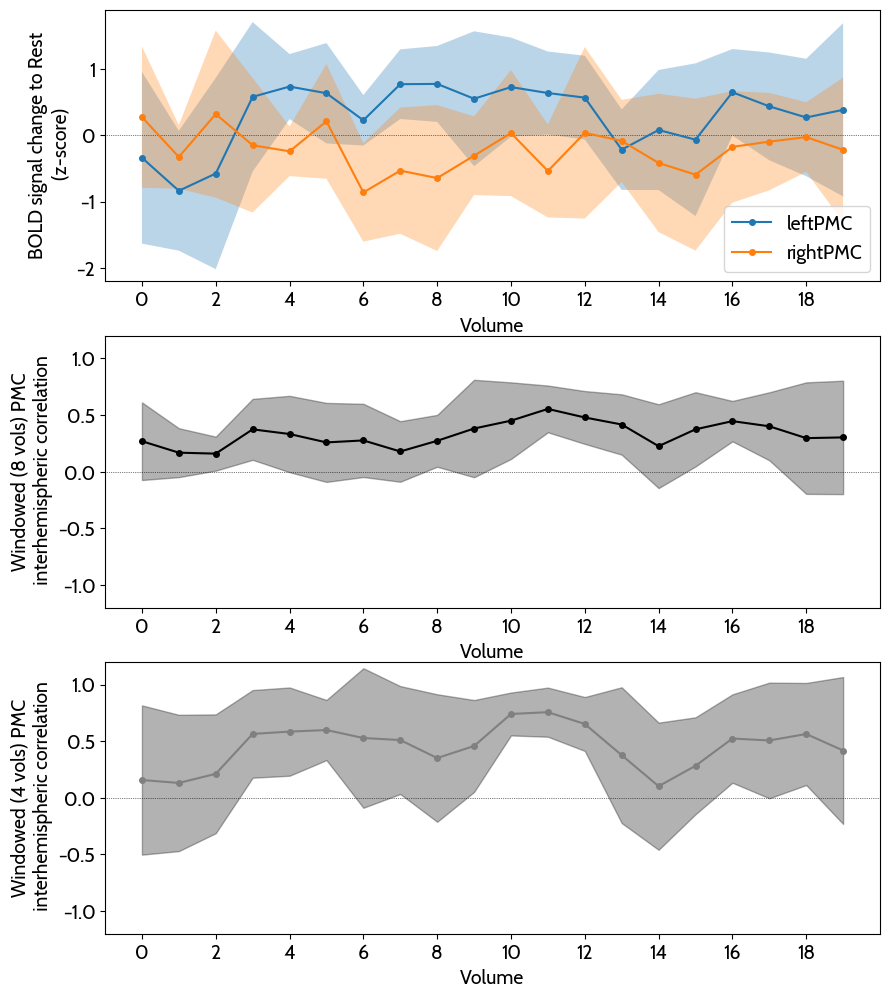

In [301]:
# subplots
plt.figure(figsize=(10, 12))

# first row
plt.subplot(3, 1, 1)

# dotted line at y = 0
plt.axhline(0, color="black", linestyle=":", linewidth=0.5)

for rr in range(len(pmc_coords)):
    plt.plot(imagery_tcs[rr, :, :].mean(axis=0), label=labels[rr], marker='o', markersize=4)

    # sd
    plt.fill_between(
        np.arange(imagery_tcs.shape[2]),
        imagery_tcs[rr, :, :].mean(axis=0) - imagery_tcs[rr, :, :].std(axis=0),
        imagery_tcs[rr, :, :].mean(axis=0) + imagery_tcs[rr, :, :].std(axis=0),
        alpha=0.3,
    )

plt.xlabel('Volume')
plt.ylabel('BOLD signal change to Rest\n (z-score)')
plt.legend()
plt.xticks(np.arange(0, 20, 2))
plt.xlim(-1, 20)

# second row
plt.subplot(3, 1, 2)

# dotted line at y = 0
plt.axhline(0, color="black", linestyle=":", linewidth=0.5)

plt.plot(correlations_online.mean(axis=0), marker='o', color='black', markersize=4)
# sd
plt.fill_between(
    np.arange(correlations_online.shape[1]),
    correlations_online.mean(axis=0) - correlations_online.std(axis=0),
    correlations_online.mean(axis=0) + correlations_online.std(axis=0),
    alpha=0.3,
    color='black',
)
plt.ylim(-1.2, 1.2)
plt.xticks(np.arange(0, 20, 2))
plt.xlim(-1, 20)

plt.xlabel('Volume')
plt.ylabel('Windowed (8 vols) PMC\n interhemispheric correlation')

# third row
plt.subplot(3, 1, 3)

# dotted line at y = 0
plt.axhline(0, color="black", linestyle=":", linewidth=0.5)

plt.plot(correlations_offline.mean(axis=0), marker='o', color='grey', markersize=4)
# sd
plt.fill_between(
    np.arange(correlations_offline.shape[1]),
    correlations_offline.mean(axis=0) - correlations_offline.std(axis=0),
    correlations_offline.mean(axis=0) + correlations_offline.std(axis=0),
    alpha=0.3,
    color='black',
)
plt.ylim(-1.2, 1.2)
plt.xticks(np.arange(0, 20, 2))
plt.xlim(-1, 20)

plt.xlabel('Volume')
plt.ylabel('Windowed (4 vols) PMC\n interhemispheric correlation')
